<center><h1 style="font-size: 37px">Supplemental Material</h1></center>

<br>
<center><h1>Simple and accurate complete elliptic integrals<br>for the full range of modulus</h1></center>
<br>
<center>Teepanis Chachiyo</center>

<center>Department of Physics, Faculty of Science, Naresuan University, Phitsanulok 65000, Thailand.</center>


### Available at a GitHub repository: [https://github.com/teepanis/elliptic-integrals](https://github.com/teepanis/elliptic-integrals)


<br>
<h2>Table of Content</h2>
<pre>

All results and figures are fully reproducible using the Python codes below.

Description ................................................................... Page


1. Subroutine description                                                        2
2. Python implementation                                                         3
3. C implementation                                                              5
4. Results: Exact K(k) and E(k) (Figure 1)                                       7
4. Results: Comparison to existing analytical forms (Figure 2)                   9
4. Results: Comparison to mathematical inequalities (Figure 3)                  11
5. Methods: Derivations of n and b for K(k)                                     13
6. Methods: Derivations of n and b for E(k)                                     14
7. Discussions: Earth orbital distance                                          15
8. Discussions: Phase space (Figure 4)                                          16
9. Discussions: Inverse K performance (Figure 5)                                19
</pre>
<div style="page-break-after: always;"></div>

<center><h2>Page 2</h2></center>

## Subroutines

Below are the subroutines introduced in this work.

#### AGM(k):
It computes exact $(K,E,\frac{dK}{dk},\frac{dE}{dk})$ to machine precision.

#### K(k):
It computes the approximation for $K(k)$ proposed in this work.

#### E(k):
It computes the approximation for $E(k)$ proposed in this work.

#### invK(K):
It computes the approximation for an inverse of $K$ in this work.

#### invK_Newton(K):
It computes an exact (up to $10^{-14}$ precision) inverse of $K$ using Newton root finding method and the proposed invK and initial guess. Additionally, $\text{nIter}$ are returned. They are the number of Newton iterations used in the computation.

<div style="page-break-after: always;"></div>

<center><h2>Page 3</h2></center>

### Python Implementation

In [1]:
import numpy as np

# AGM K and E to machine precision from Abramowitz_Stegun Eq.17.6.3-4
# If you want to check with scipy be aware that you need to use 
# scipy.special.ellipk(k**2) and scipy.special.ellipe(k**2)
def AGM(k):

    # special cases
    if k==0:
        K = np.pi/2; E = np.pi/2; dKdk = 0; dEdk = 0
    if k==1:
        K = np.inf; E = 1; dKdk = np.inf; dEdk = -np.inf

    if 0 < k and k < 1:
        a0 = 1; b0 = np.sqrt(1-k**2)
        tn = 1; S  = k**2
        while True:
            a  = (a0+b0)/2; b  = np.sqrt(a0*b0)
            tn = 2*tn; S = S + tn*(a0-b0)**2/4

            if a == a0: break
            a0 = a; b0 = b

        K = np.pi/(2*a); E = K*(1-S/2)

        dKdk = (E-(1-k**2)*K)/(k*(1-k**2))
        dEdk = (E-K)/k

    return K, E, dKdk, dEdk

#
# simple and accurate series
#

def K(k):
    #n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    #b = np.exp(n*np.pi/2) - 4**n
    # -- pre-computed for speed ---
    n = 1.3092785997521463
    b = 1.678061276031407

    # avoid numerical divide-by-zero
    if k==1: return np.inf
    
    return 1/n*np.log( (4/np.sqrt(1-k**2))**n + b)

def E(k):
    #n = np.log(3*np.pi/2 - 4)/(np.log(4) - np.pi + 3/2)
    #b = np.exp(n*(np.pi-2)) - (4/np.sqrt(np.e))**n

    # --- pre-computed for speed ---
    n = 1.3283723627880784
    b = 1.3103755722411727

    # avoid numerical divide-by-zero
    if k==1: return 1

    return 1 + 1/2*(1-k**2)/n*np.log( (4/np.sqrt(np.e)/np.sqrt(1-k**2))**n + b  )


<div style="page-break-after: always;"></div>

<center><h2>Page 4</h2></center>

In [2]:
def invK(K):
    #n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    #b = np.exp(n*np.pi/2) - 4**n
    # -- pre-computed for speed ---
    n = 1.3092785997521463
    b = 1.678061276031407

    # avoid numerical divide-by-zero
    if K==np.pi/2: return 0

    return np.sqrt(1-16/(np.exp(n*K)-b)**(2/n))

def invK_Newton(K):

    # special case
    if K==np.pi/2: return 0,0
    
    # initial guess
    k = invK(K)
    
    # safeguard
    MAX=100

    for nIter in range(1,MAX):
        Kn,En,dKdk_n,dEdk_n = AGM(k)
        dk = -(Kn-K)/dKdk_n
        k = k + dk
        if np.abs(dk)<1e-14: break

    return k, nIter


<div style="page-break-after: always;"></div>

<center><h2>Page 5</h2></center>

### C Implementation

```c
//
// Compute the exact elliptic integrals and their derivatives
//
void AGM(
double k, // input
double *K, double *E, double *dKdk, double *dEdk){ // output

    double a,b,a0,b0,tn,S;

    // special cases
    if(k==0){ *K = M_PI/2; *E = M_PI/2;
              *dKdk = 0; *dEdk = 0; }
    if(k==1){ *K = INFINITY; *E = 1;
              *dKdk = INFINITY; *dEdk = -INFINITY; }

    if(0 < k && k < 1){
        a0 = 1; b0 = sqrt(1-k*k);
        tn = 1; S  = k*k;
        while(1){
            a = (a0+b0)/2; b = sqrt(a0*b0);
            tn = 2*tn; S = S + tn*(a0-b0)*(a0-b0)/4;
            if(a0==a) break;
            a0 = a; b0 = b;
        }
        *K = M_PI/(2*a); *E = *K *(1-S/2);
        *dKdk = (*E-(1-k*k)*(*K))/(k*(1-k*k));
        *dEdk = ((*E)-(*K))/k;
    }
}

//
// simple and accurate series
//
double K(double k){
    //double n = (log(4) - log(M_PI))/(M_PI/2 - log(4));
    //double b = exp(n*M_PI/2) - pow(4,n);
    // --- pre-computed for speed ---
    double n = 1.3092785997521463;
    double b = 1.678061276031407;

    // avoid numerical divide-by-zero
    if(k==1) return INFINITY;

    return 1/n*log(pow(4/sqrt(1-k*k),n)+b);
}

double invK(double K){
    //double n = (log(4) - log(M_PI))/(M_PI/2 - log(4));
    //double b = exp(n*M_PI/2) - pow(4,n);
    // --- pre-computed for speed ---
    double n = 1.3092785997521463;
    double b = 1.678061276031407;

    // avoid numerical divide-by-zero
    if(K==M_PI/2) return 0;

    return sqrt(1-16/pow(exp(n*K)-b,2/n));
}

```

<div style="page-break-after: always;"></div>
<center><h2>Page 6</h2></center>

```c
double E(double k){
    //double n = log(3*M_PI/2 - 4)/(log(4) - M_PI + 3./2);
    //double b = exp(n*(M_PI-2)) - pow(4/sqrt(M_E),n);
    // --- pre-computed for speed ---
    double n = 1.3283723627880784;
    double b = 1.3103755722411727;

    // avoid numerical divide-by-zero
    if(k==1) return 1;

    return 1 + 1./2*(1-k*k)/n*log( 
        pow(4/sqrt(M_E)/sqrt(1-k*k),n) + b );
}

//
// Compute exact inverse of K
//
void invK_Newton(
double K, // input
double *k, int *nIter){ // output

    double dk, Kn, En, dKdk_n, dEdk_n;
    int MAX=100;

    // special case
    if(K==M_PI/2){ *k = 0.0; return; }

    // initial guess
    *k = invK(K);

    for((*nIter)=1; (*nIter)<MAX; (*nIter)++){
        AGM(*k, &Kn, &En, &dKdk_n, &dEdk_n);
        dk = -(Kn-K)/dKdk_n;
        *k = *k + dk;
        if(fabs(dk)<1e-14) break;
    }
}
```

<div style="page-break-after: always;"></div>
<center><h2>Page 7</h2></center>

# Results

### Figure 1: Exact K(k) and E(k)

The code below evaluates K and E from various methods.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# allocate amplitude thetaM and x
thetaM = np.arange(0,np.pi,.004)
k = np.sin(thetaM/2)
N = len(k)

# compute exact K(k) and E(k)
K_exact = np.zeros(N)
E_exact = np.zeros(N)
for i in range(0,N):
    K_exact[i], E_exact[i],dKdk,dEdk = AGM(k[i])

# allocate array for comparisons
K_asym = np.zeros(N)
K_t4 = np.zeros(N)
E_t4 = np.zeros(N)
K_ThisWork = np.zeros(N)
E_ThisWork = np.zeros(N)
K_lima2008 = np.zeros(N)
K_ganley1985 = np.zeros(N)

for i in range(N):
    
    # (Lima 2008)
    if k[i] > 0.0:
        a = np.sqrt(1-k[i]**2)
        K_lima2008[i] = np.pi/2*( a**2/(1-a)*np.log(1/a) +  2*k[i]**2/np.pi*np.log(4/a)   )
    else:
        K_lima2008[i] = np.pi/2
    
    K_asym[i] = np.log(4/np.sqrt(1-k[i]**2))
    K_t4[i] = np.pi/2*(1 + 1/4*k[i]**2 + ((1*3)/(2*4))**2*k[i]**4 )
    E_t4[i] = np.pi/2*(1 - 1/4*k[i]**2 - ((1*3)/(2*4))**2*k[i]**4/3 )
    
    # (Ganley 1985)
    alpha = np.sqrt(3)/2*thetaM[i]
    if alpha > 0.0: K_ganley1985[i] = np.pi/2*np.sqrt(alpha/np.sin(alpha))
    else: K_ganley1985[i] = 1.0

    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    K_ThisWork[i] = K(k[i])
    E_ThisWork[i] = E(k[i])


<div style="page-break-after: always;"></div>
<center><h2>Page 8</h2></center>

The code below plots the values of K and E.

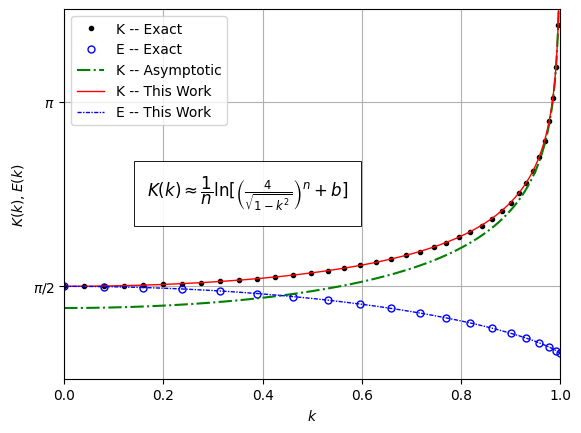

In [4]:


plt.plot(k, K_exact,'k.',markevery=20, label='K -- Exact')
plt.plot(k, E_exact,'bo',markevery=40, markersize=5, markerfacecolor='none', label='E -- Exact')
plt.plot(k, K_asym,'g-.', label='K -- Asymptotic')
#plt.plot(k, K_t4,'g--', label='K -- 4th Order Taylor')
plt.plot(k, K_ThisWork, 'r-',linewidth=1,label='K -- This Work')
plt.plot(k, E_ThisWork, 'b',linewidth=1,label='E -- This Work',
         linestyle=(0, (3, 1, 1, 1)))

plt.text(30/180,2.969/4*np.pi,'$K(k) \\approx  \\dfrac{1}{n} '
         '\\ln [   \\left(\\frac{4}{\sqrt{1-k^2}}\\right)^n + b ]$', fontsize=12, \
        bbox=dict(boxstyle='square,pad=0.8', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.7))

#plt.title('Complete Elliptical Integral of the First Kind')
plt.xlabel('$k$')
plt.ylabel('$K(k), E(k)$')
plt.yticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],['0','$\pi/2$','$\pi$','$3\\pi/2$','$2\pi$'])
plt.ylim([np.pi/4,5*np.pi/4])
plt.xlim([0,1])
plt.legend()
plt.grid()
#plt.savefig('fig_exact_KE.pdf')
plt.show()

<div style="page-break-after: always;"></div>
<center><h2>Page 9</h2></center>

### Figure 2: Comparisons to Existing Analytical Forms

The code belows plots a graph showing log-scale error profiles.

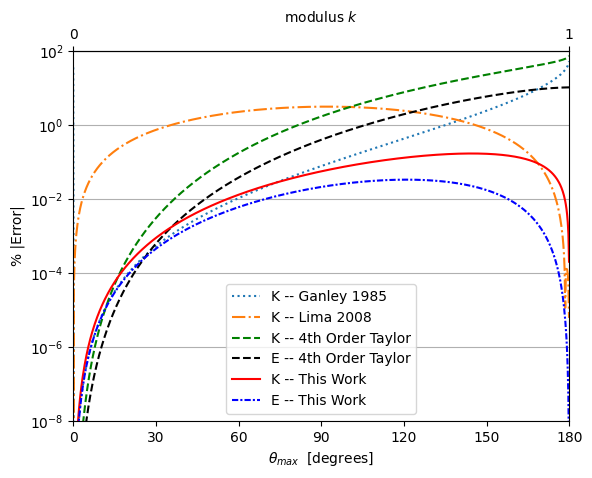

In [5]:
#
# Error comparison
#
fig, ax = plt.subplots()

ax.plot(thetaM*180/np.pi, np.abs(K_ganley1985-K_exact)*100./K_exact,':', label='K -- Ganley 1985')
ax.plot(thetaM*180/np.pi, np.abs(K_lima2008-K_exact)*100./K_exact,'-.', label='K -- Lima 2008')

ax.plot(thetaM*180/np.pi, np.abs(K_t4-K_exact)*100./K_exact,'g--', label='K -- 4th Order Taylor')
ax.plot(thetaM*180/np.pi, np.abs(E_t4-E_exact)*100./E_exact,'k--', label='E -- 4th Order Taylor')

ax.plot(thetaM*180/np.pi, np.abs(K_ThisWork-K_exact)*100./K_exact,'r-',label='K -- This Work')
ax.plot(thetaM*180/np.pi, np.abs(E_ThisWork-E_exact)*100./E_exact,'b',label='E -- This Work',
        linestyle=(0, (3, 1, 1, 1)))

#plt.title('Error compared to the exact K(k) and E(k)')
plt.xlabel('$\\theta_{max}\;$ [degrees]')
plt.ylabel('% |Error|')
plt.xlim([0,180])
plt.ylim([1e-8,1e2])
secax = ax.secondary_xaxis('top')
secax.set_xticks([0,180],['0','1'])
secax.set_xlabel('modulus $k$')
plt.legend()
plt.grid(axis='y')
plt.xticks([0,30,60,90,120,150,180])
plt.yscale('log')

#plt.savefig('fig_percent_error.pdf')
plt.show()


<div style="page-break-after: always;"></div>
<center><h2>Page 10</h2></center>

The code below compute maximum percent error.

In [6]:
## K ##
print('--- K ---')
print('Maximum % |Error|')
#print('Lima 2008: %.2f' % ( max(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work K(k): %.4f' % ( max(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

print('\nAverage % |Error|')
#print('Lima 2008: %.2f' % ( np.average(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work K(k): %.4f' % ( np.average(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

## E ##
print('\n--- E ---')
print('Maximum % |Error|')
print('This Work E(k): %.4f' % ( max(np.abs(E_ThisWork-E_exact)*100./E_exact) ) )
print('\nAverage % |Error|')
print('This Work E(k): %.4f' % ( np.average(np.abs(E_ThisWork-E_exact)*100./E_exact) ) )


--- K ---
Maximum % |Error|
This Work K(k): 0.1699

Average % |Error|
This Work K(k): 0.0648

--- E ---
Maximum % |Error|
This Work E(k): 0.0333

Average % |Error|
This Work E(k): 0.0130


<div style="page-break-after: always;"></div>
<center><h2>Page 11</h2></center>

### Figure 3: Comparisons to Existing Mathematical Inequalities

The code belows plots a graph showing upper and lower bounds from mathematical inequality studies.

From Qui et al. 1998,
$$ K^\text{lower} = \ln(\frac{4}{k'} + c k') \quad K^\text{upper} = \ln(\frac{4}{k'} + c); \quad k' \equiv \sqrt{1-k^2},\;c = e^{\pi/2}-4$$

From Yang et al. 2016,
$$ E^\text{lower} = \frac{7 \pi}{22} \frac{1-k'^{11/4}}{1-k'^{7/4}}$$

From Yang 2018,
$$ E^\text{upper} = \frac{1-k'^{\pi/(\pi-2)}}{1-k'^{2/(\pi-2)}}$$


In [7]:
#
# Collect data points
#

Kup_QVV = np.zeros(N)
Klo_QVV = np.zeros(N)
Eup_Y   = np.zeros(N)
Elo_YCZ = np.zeros(N)

for i in range(N):

    # S. L. Qiu, M. K. Vamanamurthy and M. Vuorinen, (QVV)
    # Some inequalities for the growth of elliptic integrals, 
    # SIAM J. Math. Anal. 29 (1998), 1224ñ1237. 
    # https://doi.org/10.1137/S0036141096310491
    kp = np.sqrt(1-k[i]**2)
    c = np.exp(np.pi/2)-4
    Klo_QVV[i] = np.log(4/kp + c*kp)
    Kup_QVV[i] = np.log(4/kp + c)

    # Z. H. Yang, Y. M. Chu, and W. Zhang, (YCZ) 
    # Accurate approximations for the complete elliptic integral of the second kind,
    # J. Math. Anal. Appl. 438 (2016), 875-888. 
    # https://doi.org/10.1016/j.jmaa.2016.02.035
    if kp==1: Elo_YCZ[i] = np.pi/2
    else: Elo_YCZ[i] = 7*np.pi/22 * (1-kp**(11/4))/(1-kp**(7/4))
    
    # Z. H. Yang, 
    # Sharp approximations for the complete elliptic integrals of the second kind 
    # by one-parameter means, J. Math. Anal. Appl. 467 (2018), no. 1, 446-461.
    # https://doi.org/10.1016/j.jmaa.2018.07.020
    if kp==1: Eup_Y[i] = np.pi/2
    else: Eup_Y[i] = (1-kp**(np.pi/(np.pi-2)))/(1-kp**(2/(np.pi-2)))


<div style="page-break-after: always;"></div>
<center><h2>Page 12</h2></center>

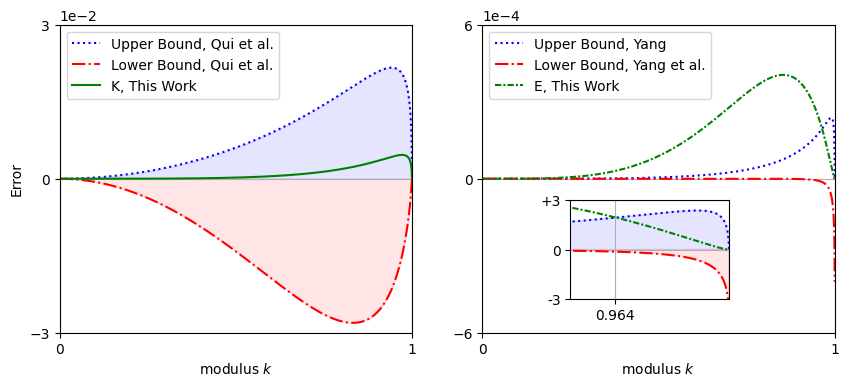

In [8]:
#
# Plot graphs
#

fig, ax = plt.subplots(1,2,figsize=(10, 4))

ax[0].plot(k, (Kup_QVV-K_exact),'b:', label='Upper Bound, Qui et al.')
ax[0].plot(k, (Klo_QVV-K_exact),'r-.', label='Lower Bound, Qui et al.')
ax[0].plot(k, (K_ThisWork-K_exact),'g-',label='K, This Work')

ax[0].fill_between(k, (Kup_QVV-K_exact), color='blue', alpha=0.1)
ax[0].fill_between(k, 0, (Klo_QVV-K_exact), color='red', alpha=0.1)

ax[1].plot(k, (Eup_Y-E_exact),'b:', label='Upper Bound, Yang')
ax[1].plot(k, (Elo_YCZ-E_exact),'r-.', label='Lower Bound, Yang et al.')
ax[1].plot(k, (E_ThisWork-E_exact),'g',label='E, This Work', linestyle=(0, (3, 1, 1, 1)))

axins = ax[1].inset_axes([0.25, 0.11, 0.45, 0.32])
axins.plot(k, (Eup_Y-E_exact),'b:')
#ax[1].fill_between(k, (Eup_Y-E_exact), color='blue', alpha=0.1)
axins.fill_between(k, (Eup_Y-E_exact), color='blue', alpha=0.1)
axins.plot(k, (Elo_YCZ-E_exact),'r-.')
#ax[1].fill_between(k, 0, (Elo_YCZ-E_exact), color='red', alpha=0.1)
axins.fill_between(k, 0, (Elo_YCZ-E_exact), color='red', alpha=0.1)
axins.plot(k, (E_ThisWork-E_exact),'g',linestyle=(0, (3, 1, 1, 1)))
axins.set_xlim(0.95,1)
axins.set_xticks([0.964])
axins.set_ylim(-3e-4,3e-4)
axins.set_yticks([-3e-4,0,+3e-4])
axins.set_yticklabels(['-3','0','+3'])
axins.grid()
#ax[1].indicate_inset_zoom(axins, edgecolor='black',linewidth=1,alpha=0.8)

ax[0].set_ylabel('Error'); #ax[1].set_ylabel('Error')
ax[0].set_xlabel('modulus $k$'); ax[1].set_xlabel('modulus $k$')
ax[0].legend()
ax[1].legend()

ax[0].grid()
ax[1].grid()

ax[0].set_xlim(0,1); ax[1].set_xlim(0,1)
ax[0].set_xticks([0,1]); ax[1].set_xticks([0,1])
ax[0].set_ylim(-3e-2,+3e-2); ax[1].set_ylim(-6e-4,+6e-4)
ax[0].set_yticks([-3e-2,0,+3e-2]); ax[1].set_yticks([-6e-4,0,+6e-4])

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 

#plt.savefig('fig_sharp_bound.pdf')
plt.show()


<div style="page-break-after: always;"></div>
<center><h2>Page 13</h2></center>

# Theoretical Method

## Derivation of the Constant $n$ and $b$ for K(k)

Below is a python code that symbollically derivatives of the proposed form, evaluated at $k = 0$. The derivatives can then be compared to that of the exact $K(k)$. Demanding that they agree upto the 2nd order will ensure that the proposed form approaches the exact limit when the amplitudes is small.

In [9]:
## checking taylor expansion of the proposed form
import sympy as sym

kk = sym.symbols('k', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

bb = sym.exp(nn*sym.pi/2) - 4**nn

# the proposed form
K0 = 1/nn*sym.ln((4/sym.sqrt(1-kk**2))**nn + bb)

from IPython.display import display
print('0th Derivative: '); display(K0.subs(kk,0))
K1 = K0.diff(kk)
print('1st Derivative: '); display(K1.subs(kk,0))
K2 = K1.diff(kk)
print('2nd Derivative: '); display(K2.subs(kk,0))
K3 = K2.diff(kk)
print('3rd Derivative: '); display(K3.subs(kk,0))

0th Derivative: 


pi/2

1st Derivative: 


0

2nd Derivative: 


4**n*exp(-pi*n/2)

3rd Derivative: 


0

The value $b$ such that $K(0) = \frac{\pi}{2}$ exactly, is quite easy to find. In this case,

$$b = e^{n\pi/2} - 4^n \tag{S1}$$

Taylor series (sometimes called power series) of the exact $K(k)$ is

$$K(k) = \frac{\pi}{2}[1 + (\frac{1}{2})^2 k^2 + (\frac{1\cdot3}{2\cdot4})^2 k^4 + (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 k^6 + \cdots]\tag{S2}$$

Therefore, $K(0) = \frac{\pi}{2}$ and $K''(0) = \frac{\pi}{4}$. From the output of the python code above, it follows that

$$4^n e^{-\frac{2\pi}{2}} = \frac{\pi}{4} \tag{S3}$$

which lead to

$$ n  = \frac{\ln 4 -  \ln \pi}{\pi/2 -  \ln 4} \quad \text{and} \quad  b  = e^{n\pi/2} - 4^n \tag{S4}$$

<br>
<div style="page-break-after: always;"></div>
<center><h2>Page 14</h2></center>

## Derivation of the Constant $n$ and $b$ for E(k)

In [10]:
## checking taylor expansion of the proposed form
import sympy as sym

kk = sym.symbols('k', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

bb = sym.exp(nn*(sym.pi-2)) - (4/sym.sqrt(sym.E))**nn

# the proposed form
K0 = 1 + (1-kk**2)/2/nn*sym.ln((4/sym.sqrt(sym.E)/sym.sqrt(1-kk**2))**nn + bb)

from IPython.display import display
print('0th Derivative: '); display(K0.subs(kk,0))
K1 = K0.diff(kk)
print('1st Derivative: '); display(K1.subs(kk,0))
K2 = K1.diff(kk)
print('2nd Derivative: '); display(K2.subs(kk,0))
K3 = K2.diff(kk)
print('3rd Derivative: '); display(K3.subs(kk,0))


0th Derivative: 


pi/2

1st Derivative: 


0

2nd Derivative: 


(4*exp(-1/2))**n*exp(-n*(-2 + pi))/2 - pi + 2

3rd Derivative: 


0

The value $b$ such that $E(0) = \frac{\pi}{2}$ exactly, is quite easy to find. In this case,

$$b = e^{n(\pi-2)} - (4\big/\!\sqrt{e})^n \tag{S5}$$

Taylor series (sometimes called power series) of the exact $E(k)$ is

$$E(k) = \frac{\pi}{2}[1 - (\frac{1}{2})^2 \frac{k^2}{1} - (\frac{1\cdot3}{2\cdot4})^2 \frac{k^4}{3} - (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 \frac{k^6}{5} - \cdots]\tag{S6}$$

Therefore, $E(0) = \frac{\pi}{2}$ and $E''(0) = -\frac{\pi}{4}$. From the output of the python code above, it follows that

$$\frac{{(4\big/\!\sqrt{e})}^n\,e^{n(2-\pi)}}{2} -\pi + 2 = -\frac{\pi}{4} \tag{S7}$$

which lead to

$$ n  = \frac{\ln(3\pi/2-4)}{\ln 4 - \pi + 3/2} \quad \text{and} \quad  b  = e^{n(\pi-2)} - (4\big/\!\sqrt{e})^n \tag{S8}$$

<br>
<div style="page-break-after: always;"></div>
<center><h2>Page 15</h2></center>

# Discussions

### Earth Orbital Distance

In [11]:
# Info from Nasa Earth fact-sheet
R = 149.598e6
eccen = .0167

K_exact,E_exact,dKdk,dEdk = AGM(eccen)
print("Assume Circle:     [km]", 2*np.pi*R/1e3)
print("Ellipse: Exact     [km]", 4*R*E_exact/1e3)
print("Ellipse: This Work [km]", 4*R*E(eccen)/1e3)
print("Error:             [cm]", 4*R*(E(eccen)-E_exact)*1e2)

Assume Circle:     [km] 939951.9555834518
Ellipse: Exact     [km] 939886.4163558404
Ellipse: This Work [km] 939886.416429983
Error:             [cm] 7.414262979565933


<div style="page-break-after: always;"></div>
<center><h2>Page 16</h2></center>

### Figure 4 Phase-Space

In [12]:
import numpy as np
import matplotlib.pyplot as plt

##
## Solutions from "Exact frequency-domain solutions 
## for nonlinear pendulum-like dynamics" (2025).
## https://github.com/teepanis/nonlinear-pendulum
## https://arxiv.org/abs/2504.16816
##
## plotting phase-space
##
## return:
## theta, omega - trajectory in the phase space
## Omega        - all elements have identical value
##                of Omega0 (for specifying color
##                of each point on the graph)               
##
def phase_space(omegaM, g, L, maxN=20):

    # trivial case
    if omegaM == 0:
        theta = np.zeros(1)
        omega = np.zeros(1)
        Omega = np.zeros(1)
        return theta, omega, Omega

    OmegaL = np.sqrt(g/L)
    omegac = 2*OmegaL
    k = omegaM/omegac
    
    #
    # compute time sampling
    #
    dt = 0.005
    
    # swinging
    if omegaM < omegac:
        T = 4*K(k)/OmegaL
        delta = -np.pi/2
        t = np.arange(0,T/2,dt)
        Omega0 = 2*np.pi/T
        
    # stopping
    elif omegaM == omegac:
        # start with 99.9% of -PI
        theta0 = -99.9/100*np.pi
        delta = 1/2*np.log((1+np.sin(theta0/2))/(1-np.sin(theta0/2)))
        # time to reach 99.9% of +PI
        T = ( np.arctanh(np.sin(99.9/100*np.pi/2)) -  delta )/OmegaL
        t = np.arange(0,T,dt)
        Omega0 = 0
        
    # spinning
    else:
        T = 2*K(1/k)/k/OmegaL
        delta = -2*np.pi
        t = np.arange(0,2*T,dt)
        Omega0 = 2*np.pi/T
        

    theta = np.zeros(len(t))
    omega = np.zeros(len(t))

    #
    # plot upper-half phase space
    #
    
    # swinging motion
    if omegaM < omegac:

        kappa = K(np.sqrt(1-k**2))

        # adding odd harmonics
        for n in range(1,maxN,2):
            a = 4/n/np.cosh(kappa*n*Omega0/OmegaL)
            theta = theta + a*np.sin(n*Omega0*t + n*delta)
            omega = omega + a*np.cos(n*Omega0*t + n*delta)*n*Omega0
    
    # stopping motion
    elif omegaM == omegac:
        theta = 2*np.arcsin( np.tanh(OmegaL*t+delta) )
        omega = 2*OmegaL/np.cosh( OmegaL*t+delta )

    # spinning motion
    else:
        
        kappa = K(np.sqrt(1-1/k**2))/k

        # adding harmonics
        for n in range(1,maxN):
            b = 2/n/np.cosh(kappa*n*Omega0/OmegaL)
            theta = theta + b*np.sin(n*Omega0*t + n*delta)
            omega = omega + b*np.cos(n*Omega0*t + n*delta)*n*Omega0

        # linear term
        theta = theta + Omega0*t + delta
        omega = omega + Omega0


    return theta, omega, np.ones(len(t))*Omega0


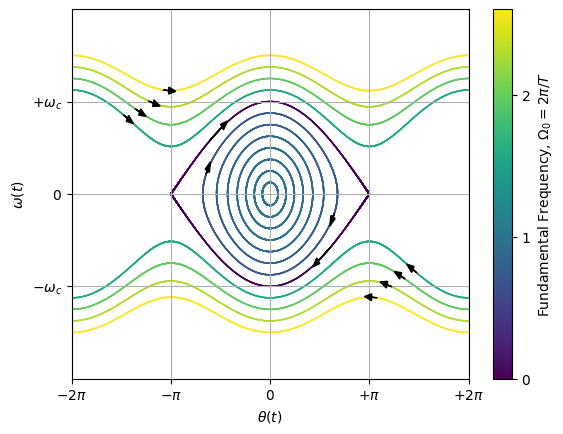

In [13]:
m = 1.0
g = 9.8
# linear (natural) angular frequency of a pendulum
OmegaL = 1
L = g/OmegaL**2

omegac = 2*np.sqrt(g/L)
omegaM = np.linspace(0,1.5,13)*omegac

# delete the first with zero speed
omegaM = np.delete(omegaM,0)

theta = np.zeros(0)
omega = np.zeros(0)
Omega = np.zeros(0)
for i in range(len(omegaM)):
    thetaT, omegaT, OmegaT = phase_space(omegaM[i], g, L)

    theta = np.append(theta, thetaT)
    omega = np.append(omega, omegaT)
    Omega = np.append(Omega, OmegaT)
    
    # draw customized arrows
    def draw_arrow(sI,fI):
        plt.arrow(thetaT[sI], omegaT[sI],
                  thetaT[fI]-thetaT[sI], omegaT[fI]-omegaT[sI],
                  shape='full', lw=1, length_includes_head=False, head_width=.15,facecolor='k',zorder=3)
        # mirror 
        plt.arrow(-thetaT[sI], -omegaT[sI],
          -thetaT[fI]+thetaT[sI], -omegaT[fI]+omegaT[sI],
          shape='full', lw=1, length_includes_head=False, head_width=.15,facecolor='k',zorder=3)  

    if i==6: draw_arrow(100,100+15);
    if i==7: draw_arrow(1200,1200+60);
    if i>=8: draw_arrow(i*20,i*20+15);
    

## upper-half
plt.scatter(theta,omega,c=Omega,cmap='viridis',s=1,marker='o',linewidths=.1)

## mirror lower-half
plt.scatter(-theta,-omega,c=Omega,cmap='viridis',s=1,marker='o',linewidths=.1)

plt.xlim(-2*np.pi,2*np.pi)
plt.ylim(-2*omegac,2*omegac)
plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi],
           ['$-2\pi$','$-\pi$','$0$','$+\pi$','$+2\pi$'])
plt.yticks([-omegac,0,+omegac],
           ['$-\\omega_c$','$0$','$+\\omega_c$'])
plt.xlabel('$\\theta(t)$')
plt.ylabel('$\\omega(t)$')

plt.colorbar(label='Fundamental Frequency, $\\Omega_0 = 2\pi/T$',ticks=[0,1,2])
plt.grid()
plt.show()
#plt.savefig('fig_phase_space.pdf')

<div style="page-break-after: always;"></div>
<center><h2>Page 19</h2></center>

### Figure 5 Inverse K performance

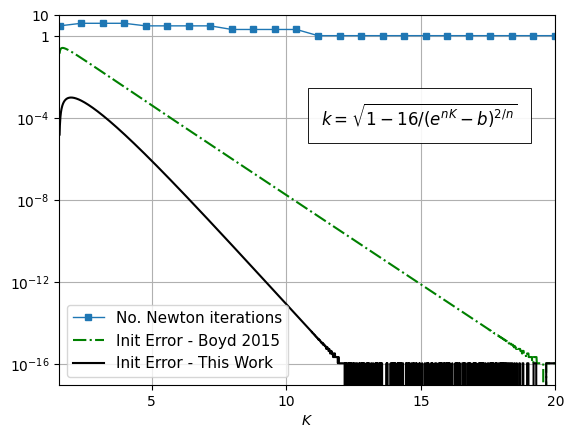

Max Error:  0.0009696795924981627
Max Percent Error:  0.12410178822665986


In [14]:
import numpy as np
import matplotlib.pyplot as plt

dK = 0.01
K = np.arange(np.pi/2+dK,20,dK)
k_exact = np.zeros(len(K))
k_thiswork = np.zeros(len(K))
k_Boyd = np.zeros(len(K))
nIter = np.zeros(len(K))

for i in range(len(K)):
    k_exact[i], nIter[i] = invK_Newton(K[i])
    k_thiswork[i] = invK(K[i])
    
    d0 = 8/np.pi
    d1 = 4*(4-np.pi)/np.pi/(np.pi-4*np.log(2))
    d2 = d1/2
    lambdaB = K[i]-np.pi/2
    k_Boyd[i] = 1-np.exp(-lambdaB*(d0+d1*lambdaB)/(1+d2*lambdaB))

plt.plot(K[::80], nIter[::80],'s-',label='No. Newton iterations',
         markersize=5,linewidth=1)
plt.plot(K, np.abs(k_Boyd-k_exact),'g-.',label='Init Error - Boyd 2015')
plt.plot(K, np.abs(k_thiswork-k_exact),'k-',label='Init Error - This Work')
plt.yscale('log')
#plt.title('Performance of inverse K computation')
plt.xticks([0,5,10,15,20])
plt.yticks([1e-16,1e-12,1e-8,1e-4,1e0,1e1],
           ['$10^{-16}$','$10^{-12}$','$10^{-8}$','$10^{-4}$','$1$','$10$'])
plt.ylim(1e-17,1e1)
plt.xlim(np.pi/2,20)
plt.xlabel('$K$')
plt.legend(fontsize=11,loc='lower left')
plt.grid()

plt.text(11.3,4.25e-5,'$k = \\sqrt{1-16/(e^{nK}-b)^{2/n}}$', fontsize=12, \
        bbox=dict(boxstyle='square,pad=0.8', facecolor='white', 
                  alpha=0.9, edgecolor='black', linewidth=0.7))

#plt.savefig('fig_performance_inverseK.pdf')
plt.show()

print('Max Error: ', np.max(np.abs(k_thiswork-k_exact)))
print('Max Percent Error: ', np.max(np.abs((k_thiswork-k_exact)*100./k_exact)))